In [ ]:
# mount git hub repo
!git clone https://github.com/gamma-opt/icnn.git


Cloning into 'icnn'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 29 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 117.99 KiB | 5.36 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
# install julia
%%shell
set -e
wget -nv https://raw.githubusercontent.com/joaquimg/SBPO2024/main/install_colab.sh -O /tmp/install_colab.sh
bash /tmp/install_colab.sh  # Takes ~ 2 minutes

2024-11-21 14:52:17 URL:https://raw.githubusercontent.com/joaquimg/SBPO2024/main/install_colab.sh [1058/1058] -> "/tmp/install_colab.sh" [1]
Installing Julia 1.10.5 on the current Colab Runtime...
2024-11-21 14:52:19 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.5-linux-x86_64.tar.gz [173909866/173909866] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.10


Now,
- go to the "Runtime" tab
- select "Change runtime type"
- select julia in the "Runtime type" dropdown
- click "save"

You might need to refresh the page.


In [1]:
import Pkg
Pkg.add("Gogeta")
Pkg.add("JuMP")
Pkg.add("Plots")
Pkg.add("JSON")
Pkg.add("Alpine")
Pkg.add("HiGHS")
Pkg.add("Juniper")
Pkg.add("Ipopt")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed ScientificTypesBase ───────── v3.0.0
   Installed GPUArraysCore ─────────────── v0.2.0
   Installed RealDot ───────────────────── v0.1.0
   Installed IrrationalConstants ───────── v0.2.2
   Installed IRTools ───────────────────── v0.4.14
   Installed Transducers ───────────────── v0.4.84
   Installed MutableArithmetics ────────── v1.6.0
   Installed Adapt ─────────────────────── v4.1.1
   Installed DiffRules ─────────────────── v1.15.1
   Installed Functors ──────────────────── v0.4.12
   Installed ContextVariablesX ─────────── v0.1.3
   Installed HypergeometricFunctions ───── v0.3.25
   Installed ShowCases ─────────────────── v0.1.0
   Installed ArgCheck ──────────────────── v2.4.0
   Installed MLJModelInterface ─────────── v1.11.0
   Installed StatsFuns ─────────────────── v1.3.2
   Installed Flux ──────────────────────── v0.14.25
   Installed FLoopsBase ────────────────── v0.1.1

In [ ]:
using Pkg
Pkg.add("IJulia")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [1]:
using Gogeta
using JuMP
using Plots
using JSON
using Alpine
using HiGHS
using Juniper
using Ipopt
using IJulia

In [2]:
include("../../src/bound.jl")
include("../../src/branch.jl")
include("../../src/envelope.jl")
include("../../src/solver.jl")
include("../../src/util.jl")

forwardpass (generic function with 1 method)

In [3]:
# replace with the path to the model_weights.json file
filepath = "model_weights_3D.json"

# Read the JSON file
json_content = read(filepath, String)

# Parse the JSON content
parsed_json = JSON.parse(json_content)

Dict{String, Any} with 3 entries:
  "FC2"   => Any[Any[Any[0.930625], Any[0.910696], Any[1.24932], Any[0.745088]]…
  "SKIP2" => Any[Any[Any[0.980311], Any[1.031]]]
  "FC1"   => Any[Any[Any[-1.02581, -0.362694, 0.285553, -1.45823], Any[-0.36712…

In [4]:
# define the icnn model
icnn_lp =  Model(alpine_optimiser)

# define the output variable
icnn_output_var = @variable(icnn_lp, z, base_name="output_var")

# define the input variable as a vector with 2 elements
icnn_input_var = @variable(icnn_lp, x[1:2], base_name="input_var")

# define the objective function
@objective(icnn_lp, Min, 0)

# add variables, constraints, and an objective function to the icnn_lp model to account for the generated ICNN.
ICNN_incorporate!(icnn_lp, filepath, icnn_output_var, icnn_input_var...)

output_var

In [5]:
print(icnn_lp)

Min output_var
Subject to
 -input_var[1] + _[4] == 0
 -input_var[2] + _[5] == 0
 output_var - _[10] == 0
 _[6] >= 0
 _[7] >= 0
 _[8] >= 0
 _[9] >= 0
 1.0258097648620605 _[4] + 0.3671203851699829 _[5] + _[6] >= -0.03923758864402771
 0.3626936972141266 _[4] + 1.131503701210022 _[5] + _[7] >= -0.010650800541043282
 -0.28555333614349365 _[4] + 0.8351008892059326 _[5] + _[8] >= -0.0065459138713777065
 1.4582306146621704 _[4] - 0.42298802733421326 _[5] + _[9] >= -0.017148861661553383
 -0.9803107976913452 _[4] - 1.0309995412826538 _[5] - 0.9306246042251587 _[6] - 0.910696268081665 _[7] - 1.2493222951889038 _[8] - 0.7450882792472839 _[9] + _[10] >= -0.37679436802864075


In [36]:
# initial setup
lb = [-1.0, -1.0]
ub = [1.0, 1.0]
box = Box(2, lb, ub)

Box(2, [-1.0, -1.0], [1.0, 1.0])

In [37]:
#---------------------------Out ICNN-----------------------------------------------#
# define the outter jump model
out_icnn_lp = copy(icnn_lp)
set_optimizer(out_icnn_lp, alpine_optimiser)

# define the objective
@objective(out_icnn_lp, Min, 0)

for i in 1:box.n
    @constraint(out_icnn_lp, out_icnn_lp[:x][i] >= box.lb[i])  # Lower bound constraint
    @constraint(out_icnn_lp, out_icnn_lp[:x][i] <= box.ub[i])  # Upper bound constraint
end


In [38]:
print(out_icnn_lp)

Min 0
Subject to
 -input_var[1] + _[4] == 0
 -input_var[2] + _[5] == 0
 output_var - _[10] == 0
 _[6] >= 0
 _[7] >= 0
 _[8] >= 0
 _[9] >= 0
 1.0258097648620605 _[4] + 0.3671203851699829 _[5] + _[6] >= -0.03923758864402771
 0.3626936972141266 _[4] + 1.131503701210022 _[5] + _[7] >= -0.010650800541043282
 -0.28555333614349365 _[4] + 0.8351008892059326 _[5] + _[8] >= -0.0065459138713777065
 1.4582306146621704 _[4] - 0.42298802733421326 _[5] + _[9] >= -0.017148861661553383
 -0.9803107976913452 _[4] - 1.0309995412826538 _[5] - 0.9306246042251587 _[6] - 0.910696268081665 _[7] - 1.2493222951889038 _[8] - 0.7450882792472839 _[9] + _[10] >= -0.37679436802864075
 input_var[1] >= -1
 input_var[2] >= -1
 input_var[1] <= 1
 input_var[2] <= 1


# Without B&B

## Example 1: z >= 0.5

In [52]:
#---------------------------Example 1----------------------------------------------#

out_icnn_lp_exm1 = copy(out_icnn_lp)
set_optimizer(out_icnn_lp_exm1, alpine_optimiser)

# add contraint on the output variable
@constraint(out_icnn_lp_exm1, exm_1, out_icnn_lp_exm1[:z] >= 0.5)

# define the objective
@objective(out_icnn_lp_exm1, Min, out_icnn_lp_exm1[:z])

println(out_icnn_lp_exm1)

# optimize the outter jump model
optimize!(out_icnn_lp_exm1)

Min output_var
Subject to
 -input_var[1] + _[4] == 0
 -input_var[2] + _[5] == 0
 output_var - _[10] == 0
 _[6] >= 0
 _[7] >= 0
 _[8] >= 0
 _[9] >= 0
 1.0258097648620605 _[4] + 0.3671203851699829 _[5] + _[6] >= -0.03923758864402771
 0.3626936972141266 _[4] + 1.131503701210022 _[5] + _[7] >= -0.010650800541043282
 -0.28555333614349365 _[4] + 0.8351008892059326 _[5] + _[8] >= -0.0065459138713777065
 1.4582306146621704 _[4] - 0.42298802733421326 _[5] + _[9] >= -0.017148861661553383
 -0.9803107976913452 _[4] - 1.0309995412826538 _[5] - 0.9306246042251587 _[6] - 0.910696268081665 _[7] - 1.2493222951889038 _[8] - 0.7450882792472839 _[9] + _[10] >= -0.37679436802864075
 input_var[1] >= -1
 input_var[2] >= -1
 exm_1 : output_var >= 0.5
 input_var[1] <= 1
 input_var[2] <= 1


*** Alpine ended with status OPTIMAL ***


In [ ]:
# save the input and output values
x1_optimal = value.(out_icnn_lp_exm1[:x][1])
x2_optimal = value.(out_icnn_lp_exm1[:x][2])
out_z_optimal = value.(out_icnn_lp_exm1[:z])

icnn_z_optimal = forwardpass(icnn_lp, [x1_optimal, x2_optimal])

# println("Objective value: ", obj_optimal)
println("x value: ", [x1_optimal, x2_optimal])
println("z value: ", out_z_optimal)
println("icnn(x) value: ", icnn_z_optimal)


*** Alpine ended with status OPTIMAL ***
x value: [-0.0097178, -0.0060493]
z value: 0.5
icnn(x) value: -0.3925577


In [54]:
using Base.Iterators: product

# Define the function f(x) = x1^2+x2^2
f(x1,x2) = x1^2+x2^2

# Generate data for plotting
x1_values = collect(-1:0.1:1)
x2_values = collect(-1:0.1:1)

# Create all combinations of x1 and x2
input_pairs = collect(product(x1_values, x2_values))

# Convert tuples to arrays if needed
input_pairs = [ [x, y] for (x, y) in input_pairs ]

# Initialize output array
icnn_outputs = zeros(length(input_pairs))

# Loop over input pairs
for i in 1:length(input_pairs)
    icnn_outputs[i] = forwardpass(icnn_lp, input_pairs[i])
end

# Create a hyperplane z = 0.5
Z_plane = 0.5 * ones(length(input_pairs))


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTI

441-element Vector{Float64}:
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 ⋮
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\yliuc\.julia\packages\Plots\MR7sb\src\backends\gr.jl:528
┌ Warning: Multiple series with different fill alpha share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\yliuc\.julia\packages\Plots\MR7sb\src\backends\gr.jl:528
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\yliuc\.julia\packages\Plots\MR7sb\src\backends\gr.jl:528
┌ Warning: Multiple series with different fill alpha share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\yliuc\.julia\packages\Plots\MR7sb\src\backends\gr.jl:528
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\yliuc\.julia\packages\Plots\MR7sb\src\backends\gr.jl:528
┌ Warning: Multiple series with dif

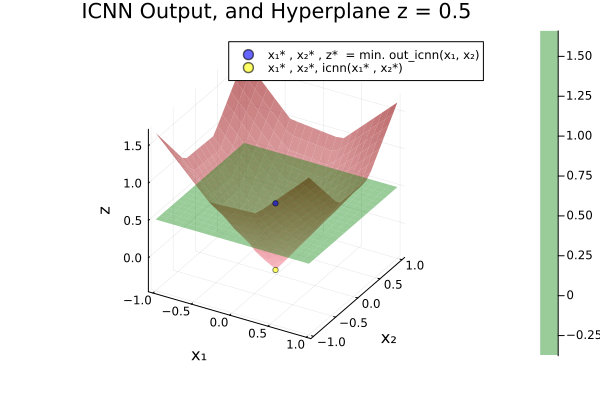

In [55]:
# Select a backend (optional)
gr()

# Plot the  ICNN surface
plt1 = surface(
    x1_values, x2_values, icnn_outputs,
    xlabel = "x₁",
    ylabel = "x₂",
    zlabel = "z",
    title = "ICNN Output, and Hyperplane z = 0.5",
    color = :reds,
    opacity = 0.6,
    label = "ICNN Output Surface"
)


# Add the hyperplane to the plot
surface!(
    x1_values, x2_values, Z_plane,
    color = :green,
    opacity = 0.4,
    label = "z = 0.5 Hyperplane"
)


# Add the 3D point to the plot
scatter!(
    [x1_optimal], [x2_optimal], [out_z_optimal],
    color = :blue,
    markerstrokecolor = :black,
    markersize = 3,
    opacity = 0.6,
    label = "x₁* , x₂* , z*  = min. out_icnn(x₁, x₂)"
)


# Add the 3D point to the plot
scatter!(
    [x1_optimal], [x2_optimal], [icnn_z_optimal],
    color = :yellow,
    markersize = 3,
    opacity = 0.6,
    label = "x₁* , x₂*, icnn(x₁* , x₂*) "
)

# Add legend and adjust the camera angle
plot!(
    legend = :topright,
)


# Display the plot
display(plt1)


## Example 2: max x₁+z, z>=0.5

In [59]:
#---------------------------Example 2---------------------------------------------#
out_icnn_lp_exm2 = copy(out_icnn_lp)
set_optimizer(out_icnn_lp_exm2, alpine_optimiser)

# add contraint on the output variable
@constraint(out_icnn_lp_exm2, exm_2, out_icnn_lp_exm2[:z] >= 0.5)

# define the objective
@objective(out_icnn_lp_exm2, Max, out_icnn_lp_exm2[:x][1]+out_icnn_lp_exm2[:z])    # eliminate penalty term to keep the same objective function as the envelope relaxation

println(out_icnn_lp_exm2)

# optimize the outter jump model
optimize!(out_icnn_lp_exm2)

Max input_var[1] + output_var
Subject to
 -input_var[1] + _[4] == 0
 -input_var[2] + _[5] == 0
 output_var - _[10] == 0
 _[6] >= 0
 _[7] >= 0
 _[8] >= 0
 _[9] >= 0
 1.0258097648620605 _[4] + 0.3671203851699829 _[5] + _[6] >= -0.03923758864402771
 0.3626936972141266 _[4] + 1.131503701210022 _[5] + _[7] >= -0.010650800541043282
 -0.28555333614349365 _[4] + 0.8351008892059326 _[5] + _[8] >= -0.0065459138713777065
 1.4582306146621704 _[4] - 0.42298802733421326 _[5] + _[9] >= -0.017148861661553383
 -0.9803107976913452 _[4] - 1.0309995412826538 _[5] - 0.9306246042251587 _[6] - 0.910696268081665 _[7] - 1.2493222951889038 _[8] - 0.7450882792472839 _[9] + _[10] >= -0.37679436802864075
 input_var[1] >= -1
 input_var[2] >= -1
 exm_2 : output_var >= 0.5
 input_var[1] <= 1
 input_var[2] <= 1


*** Alpine ended with status OPTIMAL ***


In [61]:
# save the input and output values
x1_optimal = value.(out_icnn_lp_exm2[:x][1])
x2_optimal = value.(out_icnn_lp_exm2[:x][2])
out_z_optimal = value.(out_icnn_lp_exm2[:z])

icnn_z_optimal = forwardpass(icnn_lp, [x1_optimal, x2_optimal])

# println("Objective value: ", obj_optimal)
println("x value: ", [x1_optimal, x2_optimal])
println("z value: ", out_z_optimal)
println("icnn(x) value: ", icnn_z_optimal)


*** Alpine ended with status OPTIMAL ***
x value: [1.0, 5.3e-6]
z value: 1.0000000001e6
icnn(x) value: 0.9520865


┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\yliuc\.julia\packages\Plots\MR7sb\src\backends\gr.jl:528
┌ Warning: Multiple series with different fill alpha share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\yliuc\.julia\packages\Plots\MR7sb\src\backends\gr.jl:528
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\yliuc\.julia\packages\Plots\MR7sb\src\backends\gr.jl:528
┌ Warning: Multiple series with different fill alpha share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\yliuc\.julia\packages\Plots\MR7sb\src\backends\gr.jl:528
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\yliuc\.julia\packages\Plots\MR7sb\src\backends\gr.jl:528
┌ Warning: Multiple series with dif

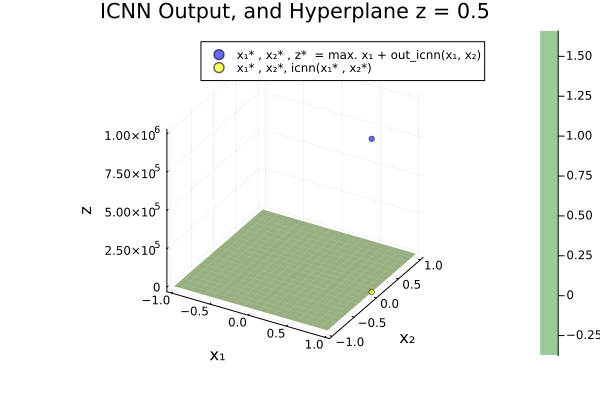

In [63]:
# Select a backend (optional)
gr()

# Plot the  ICNN surface
plt2 = surface(
    x1_values, x2_values, icnn_outputs,
    xlabel = "x₁",
    ylabel = "x₂",
    zlabel = "z",
    title = "ICNN Output, and Hyperplane z = 0.5",
    color = :reds,
    opacity = 0.6,
    label = "ICNN Output Surface"
)


# Add the hyperplane to the plot
surface!(
    x1_values, x2_values, Z_plane,
    color = :green,
    opacity = 0.4,
    label = "z = 0.5 Hyperplane"
)


# Add the 3D point to the plot
scatter!(
    [x1_optimal], [x2_optimal], [out_z_optimal],
    color = :blue,
    markerstrokecolor = :black,
    markersize = 3,
    opacity = 0.6,
    label = "x₁* , x₂* , z*  = max. x₁ + out_icnn(x₁, x₂)"
)


# Add the 3D point to the plot
scatter!(
    [x1_optimal], [x2_optimal], [icnn_z_optimal],
    color = :yellow,
    markersize = 3,
    opacity = 0.6,
    label = "x₁* , x₂*, icnn(x₁* , x₂*) "
)

# Add legend and adjust the camera angle
plot!(
    legend = :topright,
)


# Display the plot
display(plt2)

# Using B&B

## max x₁+z, z>=0.5
True optimum: x1 = 1, x2 = 0, z = 1, objective = 2

Initial setup

In [6]:
obj_lb = -Inf # updated upwards by feasible solutions (z_optimal gap within tolerance)
x_optimal = nothing # updated with the x values of the best solution found so far

lb = [-1.0, -1.0]
ub = [1.0, 1.0]
box = Box(2, lb, ub)

Box(2, [-1.0, -1.0], [1.0, 1.0])

Level 0 root:
- without BB method, directly optimise the ICNN model with additional constraints and custom objective (no penalty term)


In [7]:
root_icnn_lp = copy(icnn_lp)
set_optimizer(root_icnn_lp, alpine_optimiser)

# define the constraints on input variable
for i in 1:box.n
    @constraint(root_icnn_lp, root_icnn_lp[:x][i] >= box.lb[i])  # Lower bound constraint
    @constraint(root_icnn_lp, root_icnn_lp[:x][i] <= box.ub[i])  # Upper bound constraint
end

# add additional contraint on the output variable
@constraint(root_icnn_lp, root_icnn_lp[:z] >= 0.5)

# overwrite the objective
@objective(root_icnn_lp, Max, root_icnn_lp[:x][1] + root_icnn_lp[:z])

print(root_icnn_lp)

Max input_var[1] + output_var
Subject to
 -input_var[1] + _[4] == 0
 -input_var[2] + _[5] == 0
 output_var - _[10] == 0
 _[6] >= 0
 _[7] >= 0
 _[8] >= 0
 _[9] >= 0
 1.0258097648620605 _[4] + 0.3671203851699829 _[5] + _[6] >= -0.03923758864402771
 0.3626936972141266 _[4] + 1.131503701210022 _[5] + _[7] >= -0.010650800541043282
 -0.28555333614349365 _[4] + 0.8351008892059326 _[5] + _[8] >= -0.0065459138713777065
 1.4582306146621704 _[4] - 0.42298802733421326 _[5] + _[9] >= -0.017148861661553383
 -0.9803107976913452 _[4] - 1.0309995412826538 _[5] - 0.9306246042251587 _[6] - 0.910696268081665 _[7] - 1.2493222951889038 _[8] - 0.7450882792472839 _[9] + _[10] >= -0.37679436802864075
 input_var[1] >= -1
 input_var[2] >= -1
 output_var >= 0.5
 input_var[1] <= 1
 input_var[2] <= 1


In [8]:
results = solve_node_models([root_icnn_lp], icnn_lp)
obj_lb, x_optimal, boxes_to_branch, all_pruned = process_results(results, [box], obj_lb, x_optimal)


----- Optimising Model 1 -----

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************


*** Alpine ended with status OPTIMAL ***
Status: OPTIMAL

*** Alpine ended with status OPTIMAL ***
Objective value: 1.0000010001000024e6
        x value: [1.0, 5.3e-6]
        z value: 1.0000000001e6
  icnn(x) value: 0.9520865
           Gap: 1.0503237342547132e6

Processing result for model 1 with box: Box(2, [-1.0, -1.0], [1.0, 1.0])
Further branching on Box(2, [-1.0, -1.0], [1.0, 1.0]) is required

Further branching on Box[Box(2, [-1.0, -1.0], [1.0, 1.0])] is required
Current lower bound: -Inf


(-Inf, nothing, Box[Box(2, [-1.0, -1.0], [1.0, 1.0])], false)

level 1:
- Further branching on Box[Box(2, [-1.0, -1.0], [1.0, 1.0])] is required

In [9]:
# Branch the box on the first dimension (x[1]) to create two new boxes
boxes_list = branch_box(box, branch_dimension=1)

new_icnn_lp_list = generate_relaxation(icnn_lp, root_icnn_lp, boxes_list)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var[1] + output_var
Subject to
 -input_var[1] + _[4] == 0
 -input_var[2] + _[5] == 0
 output_var - _[10] == 0
 input_var[1] + a[1] + a[3] == 0
 input_var[2] + a[1] + a[2] - a[3] - a[4] == 0
 constraint_4 : a[1] + a[2] + a[3] + a[4] == 1
 _[6] >= 0
 _[7] >= 0
 _[8] >= 0
 _[9] >= 0
 1.0258097648620605 _[4] + 0.3671203851699829 _[5] + _[6] >= -0.03923758864402771
 0.3626936972141266 _[4] + 1.131503701210022 _[5] + _[7] >= -0.010650800541043282
 -0.28555333614349365 _[4] + 0.8351008892059326 _[5] + _[8] >= -0.0065459138713777065
 1.4582306146621704 _[4] - 0.42298802733421326 _[5] + _[9] >= -0.017148861661553383
 -0.9803107976913452 _[4] - 1.0309995412826538 _[5] - 0.9306246042251587 _[6] - 0.910696268081665 _[7] - 1.2493222951889038 _[8] - 0.7450882792472839 _[9] + _[10] >= -0.37679436802864075
 input_var[1] >= -1


2-element Vector{Model}:
 A JuMP Model
├ solver: Alpine
├ objective_sense: MAX_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 14
├ num_constraints: 29
│ ├ AffExpr in MOI.EqualTo{Float64}: 6
│ ├ AffExpr in MOI.GreaterThan{Float64}: 14
│ ├ AffExpr in MOI.LessThan{Float64}: 5
│ └ VariableRef in MOI.GreaterThan{Float64}: 4
└ Names registered in the model
  └ :a, :constraint_3, :constraint_4, :x, :z
 A JuMP Model
├ solver: Alpine
├ objective_sense: MAX_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 14
├ num_constraints: 29
│ ├ AffExpr in MOI.EqualTo{Float64}: 6
│ ├ AffExpr in MOI.GreaterThan{Float64}: 14
│ ├ AffExpr in MOI.LessThan{Float64}: 5
│ └ VariableRef in MOI.GreaterThan{Float64}: 4
└ Names registered in the model
  └ :a, :constraint_3, :constraint_4, :x, :z

In [ ]:
results = solve_node_models(new_icnn_lp_list, icnn_lp)
obj_lb, x_optimal, boxes_to_branch, all_pruned = process_results(results, boxes_list, obj_lb, x_optimal)


----- Optimising Model 1 -----

*** Alpine ended with status OPTIMAL ***
Status: OPTIMAL

*** Alpine ended with status OPTIMAL ***
Objective value: 0.9565910846881301
        x value: [-0.0, 0.9999881]
        z value: 0.9565911
  icnn(x) value: 0.9565751
           Gap: 1.6726339625624796e-5

----- Optimising Model 2 -----

*** Alpine ended with status OPTIMAL ***
Status: OPTIMAL

*** Alpine ended with status OPTIMAL ***
Objective value: 2.6548499961143754
        x value: [1.0, -0.9999981]
        z value: 1.65485
  icnn(x) value: 1.654848
           Gap: 1.2085702129956748e-6

Processing result for model 1 with box: Box(2, [-1.0, -1.0], [0.0, 1.0])
Updated lower bound: 0.9565910846881301

Processing result for model 2 with box: Box(2, [0.0, -1.0], [1.0, 1.0])
Updated lower bound: 2.6548499961143754

All nodes are pruned, no further branching needed
      x values: [1.0, -0.9999981]
solution value: 2.6548499961143754


(2.6548499961143754, [1.0, -0.9999981], Box[], true)

All nodes are pruned, no further branching needed

`x values: [1.0, -0.9999981]`

`solution value: 2.6548499961143754`